<a href="https://colab.research.google.com/github/ashikulbarichy/Kidney-Stone-QNN/blob/main/QNN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 ▸ Install required packages
!pip install qiskit==1.3.1 qiskit-machine-learning==0.8.2 torch torchvision scikit-learn pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

Mounted at /content/drive
Detected folders: ['normal', 'stone']


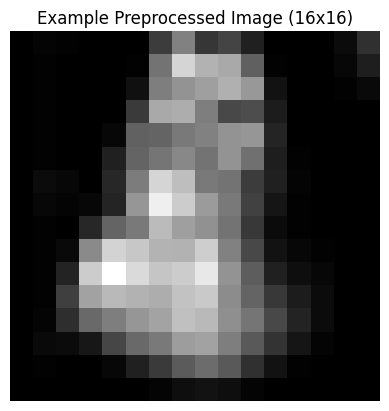

Epoch  1  loss=0.6481  acc=0.6179
Epoch  2  loss=0.6437  acc=0.6143
Epoch  3  loss=0.6411  acc=0.6107
Epoch  4  loss=0.6375  acc=0.6357
Epoch  5  loss=0.6337  acc=0.6500
Epoch  6  loss=0.6310  acc=0.6536
Epoch  7  loss=0.6259  acc=0.6679
Epoch  8  loss=0.6257  acc=0.6679
Epoch  9  loss=0.6232  acc=0.6857
Epoch 10  loss=0.6191  acc=0.7036


In [ ]:
# Cell 2 ▸ Load dataset & train QNN (auto-detect folders)

# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2) Imports
import os
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 42

# 3) Define root and auto-detect subfolders
ROOT = Path("/content/drive/MyDrive/dataset2")
if not ROOT.exists():
    raise FileNotFoundError(f"Root folder not found: {ROOT}")

subdirs = {d.name.lower(): d for d in ROOT.iterdir() if d.is_dir()}
print("Detected folders:", list(subdirs.keys()))

# Match folders case-insensitively
folder_stone  = subdirs.get("stone")
folder_normal = subdirs.get("normal")

if not folder_stone or not folder_normal:
    raise FileNotFoundError("Could not find both 'stone' and 'normal' folders under Kidney Stone Test.")

# 4) Image loading function
def load_images_from_folder(folder_path, label):
    images, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('L').resize((16, 16), Image.BILINEAR)
            img_array = np.array(img).flatten().astype(np.float32) / 255.0
            images.append(img_array)
            labels.append(label)
    return images, labels

# 5) Load dataset
stone_images, stone_labels   = load_images_from_folder(folder_stone, 1)
normal_images, normal_labels = load_images_from_folder(folder_normal, -1)

all_images = np.array(stone_images + normal_images)
all_labels = np.array(stone_labels + normal_labels)

# 6) PCA to 8D + normalize
pca = PCA(n_components=8)
reduced = pca.fit_transform(all_images)
normed = reduced / np.linalg.norm(reduced, axis=1, keepdims=True)

# 7) Train/test split
x_train, x_test, y_train, y_test = train_test_split(normed, all_labels, test_size=0.3, random_state=42)

# 8) Visualize one sample
plt.imshow(all_images[0].reshape(16, 16), cmap='gray')
plt.title("Example Preprocessed Image (16x16)")
plt.axis("off")
plt.show()

# 9) Reduce to 2D for QNN input
pca2 = PCA(n_components=2)
x_train_2d = pca2.fit_transform(x_train)

# 10) Convert labels from {-1, 1} → {0, 1}
y_train_bin = ((np.array(y_train) + 1) // 2).astype(np.int64)

# 11) Build QNN
inputs = ParameterVector('x', 2)
weights = ParameterVector('w', 4)
qc = QuantumCircuit(2)
qc.ry(inputs[0], 0)
qc.ry(inputs[1], 1)
qc.cx(0, 1)
for i in range(4):
    qc.ry(weights[i], i % 2)

parity_fn = lambda b: format(b, 'b').count('1') % 2
qnn = SamplerQNN(
    circuit=qc,
    input_params=inputs,
    weight_params=weights,
    interpret=parity_fn,
    output_shape=2,
    sampler=StatevectorSampler(),
)
qnn.input_gradients = True
model = TorchConnector(qnn)

# 12) Torch tensors
X_t = torch.tensor(x_train_2d, dtype=torch.float32)
y_t = torch.tensor(y_train_bin, dtype=torch.long)

# 13) Train
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(1, 11):
    optimizer.zero_grad()
    logits = model(X_t)
    loss = criterion(logits, y_t)
    loss.backward()
    optimizer.step()

    preds = logits.argmax(dim=1)
    acc = (preds == y_t).float().mean().item()
    print(f"Epoch {epoch:2d}  loss={loss.item():.4f}  acc={acc:.4f}")

In [ ]:
# Cell 3 ▸ Single‐image inference

# 1) Imports & display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# 2) Point to your test image here:
test_path = '/content/drive/MyDrive/my dataset final 512x512(implemented)/normal/example.png'

img = Image.open(test_path).convert('L').resize((64, 64))
plt.imshow(img, cmap='gray'); plt.axis('off')

# 3) Preprocess + PCA
arr = np.array(img, np.float32).flatten() / 255.0
x_red = pca.transform(arr.reshape(1, -1))    # (1, 2)

# 4) Inference
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(x_red, dtype=torch.float32))
    probs  = torch.softmax(logits, dim=1).numpy().ravel()
    pred   = int(logits.argmax().item())

print(f"Predicted class → {CLASS_FOLDERS[pred]} (index={pred})")
print(f"Probabilities → {dict(zip(CLASS_FOLDERS, probs))}")
